# Uncertainty on reactivity feedback coefficients using conditional expectation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np

## Theory

This method is based on the theory of conditional expectation and further develops what proposed in "*Zwermann et al., Aleatoric and epistemic uncertainties in sampling based nuclear data uncertainty and sensitivity analyses, Proceedings of PHYSOR 2012: Conference on Advances in Reactor Physics - Linking Research, Industry, and Education; Knoxville, TN (United States); 15-20 Apr 2012*".

The theory is proposed for the quantification of the output uncertainty (using stochastic sampling) generated by epistemic input uncertainties, without the contribution of aleatoric uncertainties.

Model:
$$Y=f(X) + \varepsilon$$
where:
- $X$ is the independent variable assumed as the only source of epistemic uncertainty: $X\sim \mathcal{N}(E[X], V[X])$.
- $\varepsilon$ is the homoscedastic aleatory uncertainty: $\varepsilon\sim \mathcal{N}(0, \sigma^2)$.
- $Y$ is the dependent variable affected by the uncertainty on $X$ and $\varepsilon$: $Y\sim \mathcal{N}(E[Y], V[Y])$

By the law of total variance:$$V[Y] = V[E[Y|X]]+E[V[Y|X]]$$

The first terms on the RHS being the variance *explained* by $X$, and the second term on the RHS the *fraction of variance unexplained*. 

The first term is the contribution of the mere epistemic uncertainty, free of the aleatoric component, i.e., what we are looking for.

Let's first express $V[E[Y|X]]$ for our model.

$$E[Y|X]=f(X)$$

$$V[E[Y|X]]=E[f(X)f(X)]$$

Zwermann et al. explain an alternative approach to quantify this term as $V[E[Y|X]] = Cov(Y, Y')$. Here we need to introduce a new output variable $Y'$ as

$$Y'=f(X)+\varepsilon'$$

where $\varepsilon'$ is the homoscedastic aleatory uncertainty: $\varepsilon'\sim \mathcal{N}(0, \sigma^2)$, independent from $\varepsilon$.

Now, if $Y$ and $Y'$ are identically distributed and conditionally independent the equality $V[E[Y|X]] = Cov(Y, Y')$ holds.

Let's calculate $Cov(Y, Y')$:

$$Cov(Y, Y')=E[YY']=E[(f(X)+\varepsilon)(f(X)+\varepsilon')]=E[(f(X)f(X)]+E[f(X)\varepsilon]+E[f(X)\varepsilon']+E[\varepsilon\varepsilon']=E[(f(X)f(X)]=V[E[Y|X]]$$

The practical implementation requires to draw a sample of $X$ with size $N$:$\vec x=[x_1, ...,x_N]$. Then for each $i$-th observation $x_i$ we run both models and produce observations for $Y$ and $Y'$: $y_i$ and $y_i'$.
The two vectors of observations $\vec y$ and $\vec y'$ have a common uncertainty source (the epsitemic one), and an independent source (the aleatoric one).

The sample covariance between the two vectors provides the required information:

$$Cov(Y,Y')\approx\frac{1}{N-1}(\vec{y}-\hat{\mu}_{Y})(\vec{y}'-\hat{\mu}_{Y'})^T$$

with $\hat{\mu}_{Y}$ and $\hat{\mu}_{Y'}$ being the sample means of $Y$ and $Y'$ based on $N$ observations.

This concept was applied by Zwermann et al. for the quantification of the uncertainty of k$_{eff}$ due to nuclear data in Monte Carlo transport calculations. The nucelar data were identified as the epistemic source of uncertainty, while the uncertainty due to counting statistics inherent of the Monte Carlo method was the aleatoric souncertainty source.

Here we extend this method for any sort of reactivity feedback coefficient estimated as

$$\Delta=k_2 - k_2$$

with $k_2$ and $k_1$ being k$_{eff}$ calculations for two states of a system, e.g., for instance considering two different fuel  temperatures $T_2$ and $T_1$ to quantify the Doppler reactivity coefficient.

Now, the two considered models are:

$$
\Delta = (f_2(X) + \varepsilon_2) - (f_1(X) + \varepsilon_1)
$$
$$
\Delta' = (f_2(X) + \varepsilon_2') - (f_1(X) + \varepsilon_1')
$$

with $f_2$ and $f_1$ being two transport model repectively for temperatures $T_2$ and $T_1$, and $\varepsilon_1$, $\varepsilon_2$, $\varepsilon_1'$, $\varepsilon_2'$ being all $\mathcal{N}(0, \sigma^2)$ and independent. The $\varepsilon$-terms reresent the Monte Carlo uncertainty of each simulation.

Following what previously reported, the $Cov(\Delta, \Delta')$ is

$$
Cov(\Delta, \Delta') = E[((f_2(X) + \varepsilon_2) - (f_1(X) + \varepsilon_1)) ((f_2(X) + \varepsilon_2') - (f_1(X) + \varepsilon_1'))] = E[(f_2(X)-f_1(X))^2]
$$

and

$$
V[E[\Delta|X]] = E[E[\Delta|X]E[\Delta|X]] = E[(f_2(X)-f_1(X))^2] 
$$

and then $V[E[\Delta|X]] = Cov(\Delta, \Delta')$

## Practical implementation

Below we report the practical implementation of the theory above for a simple problem in which we control:
- the sample size $N$
- the number of parameters $M$
- the magnitude of the aleatoric uncertainty source $sigma\_err$, and the corresponiding fraction of variance $FV$

Using a simple test problem we can study how the equations above converge to the analytical solution as a function of the control parameters.

### Convergence with stat. uncertainty magnitude

In [3]:
N = 10000
mu = 5
std = 2
X = std * np.random.randn(N) + mu

In [4]:
def f(x, sigma_err=1):  # equal to f1
    return 3 * x + sigma_err * np.random.randn(x.size)

def g(x, sigma_err=1):  # equal to f2
    return 3.1 * x + sigma_err * np.random.randn(x.size)

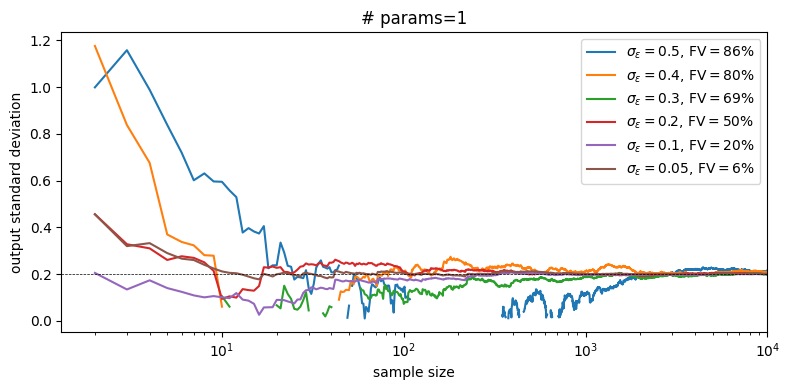

In [5]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

sigma_err = .5
FV = sigma_err**2 / (0.2**2 + sigma_err**2) * 100
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"$\\sigma_\\varepsilon={sigma_err}$, FV$={FV:.0f}$%")

sigma_err = .4
FV = sigma_err**2 / (0.2**2 + sigma_err**2) * 100
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"$\\sigma_\\varepsilon={sigma_err}$, FV$={FV:.0f}$%")

sigma_err = .3
FV = sigma_err**2 / (0.2**2 + sigma_err**2) * 100
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"$\\sigma_\\varepsilon={sigma_err}$, FV$={FV:.0f}$%")

sigma_err = .2
FV = sigma_err**2 / (0.2**2 + sigma_err**2) * 100
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"$\\sigma_\\varepsilon={sigma_err}$, FV$={FV:.0f}$%")

sigma_err = .1
FV = sigma_err**2 / (0.2**2 + sigma_err**2) * 100
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"$\\sigma_\\varepsilon={sigma_err}$, FV$={FV:.0f}$%")

sigma_err = .05
FV = sigma_err**2 / (0.2**2 + sigma_err**2) * 100
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"$\\sigma_\\varepsilon={sigma_err}$, FV$={FV:.0f}$%")

ax.axhline(0.2, ls="--", color="k", lw=.5)
ax.legend()
ax.set(xlim=[None, N], ylabel="output standard deviation", xlabel="sample size", title=f"# params=1")
fig.tight_layout()

### Convergence with number of parameters

In [6]:
N = 5000
mu = 5
std = 2

In [7]:
def f(x, sigma_err=1):
    return X @ np.array([1] * X.shape[1]) + sigma_err * np.random.randn(X.shape[0])

def g(x, sigma_err=1):
    return X @ np.array([1.01] * X.shape[1]) + sigma_err * np.random.randn(X.shape[0])

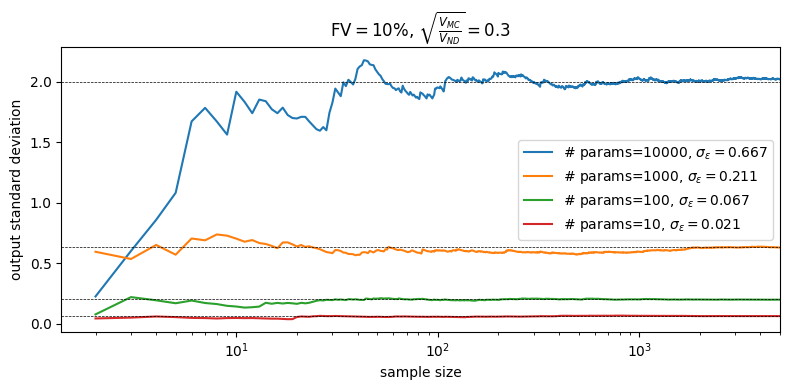

In [8]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

FV = 10

M = 10000
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 1000
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 100
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 10
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

ax.legend()
ax.set(xlim=[None, N], ylabel="output standard deviation", xlabel="sample size",
       title=f"FV$={FV:.0f}$%, " + "$\\sqrt{\\frac{V_{MC}}{V_{ND}}}=$" + f"${VR:.1f}$")
fig.tight_layout()

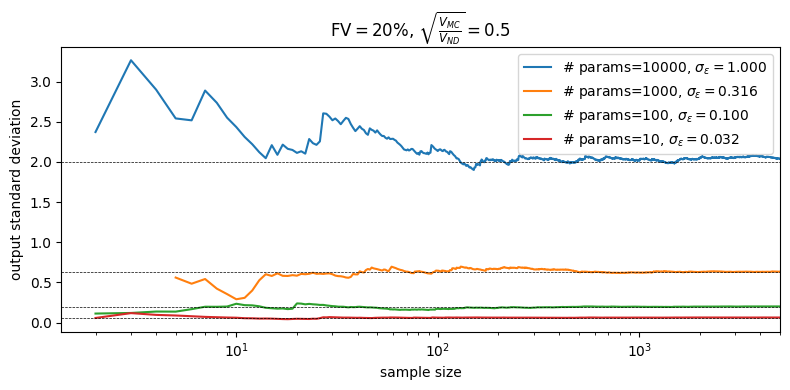

In [9]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

FV = 20

M = 10000
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 1000
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 100
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 10
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

ax.legend()
ax.set(xlim=[None, N], ylabel="output standard deviation", xlabel="sample size",
       title=f"FV$={FV:.0f}$%, " + "$\\sqrt{\\frac{V_{MC}}{V_{ND}}}=$" + f"${VR:.1f}$")
fig.tight_layout()

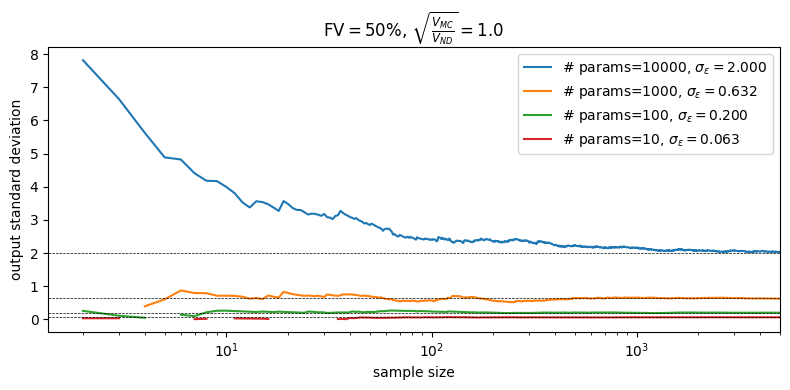

In [10]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

FV = 50

M = 10000
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 1000
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 100
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 10
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

ax.legend()
ax.set(xlim=[None, N], ylabel="output standard deviation", xlabel="sample size",
       title=f"FV$={FV:.0f}$%, " + "$\\sqrt{\\frac{V_{MC}}{V_{ND}}}=$" + f"${VR:.1f}$")
fig.tight_layout()

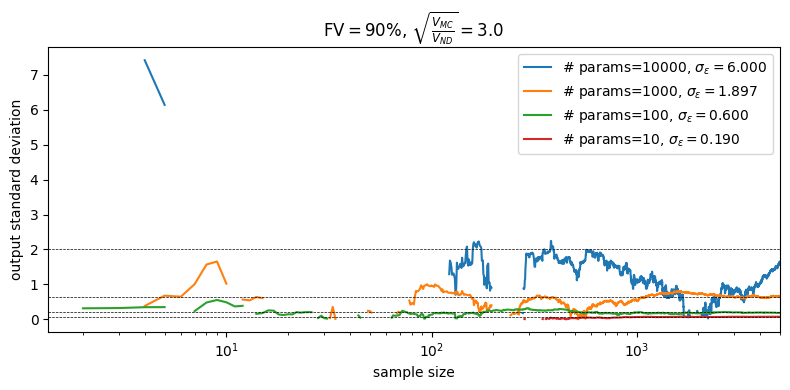

In [11]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

FV = 90

M = 10000
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 1000
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 100
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 10
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

ax.legend()
ax.set(xlim=[None, N], ylabel="output standard deviation", xlabel="sample size",
       title=f"FV$={FV:.0f}$%, " + "$\\sqrt{\\frac{V_{MC}}{V_{ND}}}=$" + f"${VR:.1f}$")
fig.tight_layout()

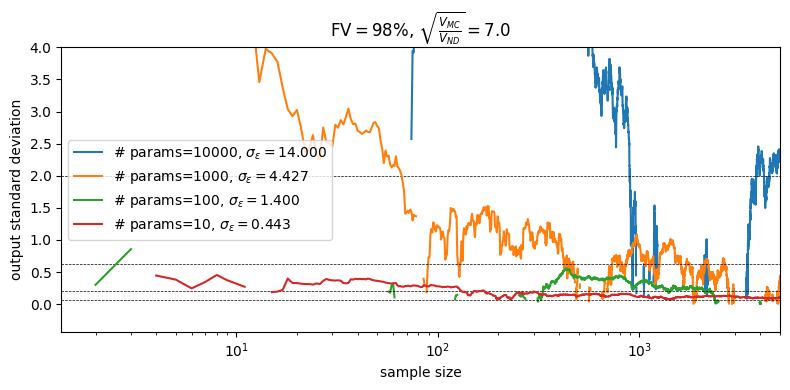

In [12]:
%%capture --no-display
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

FV = 98

M = 10000
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 1000
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 100
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

M = 10
S = np.sqrt(0.01**2 * std**2 * M)
sigma_err = np.sqrt((FV/100)/(1-FV/100))*S
VR = sigma_err / S
X = std * np.random.randn(N, M) + mu
Y1 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
Y2 = g(X, sigma_err=sigma_err) - f(X, sigma_err=sigma_err)
s = pd.Series({nsmp: np.sqrt(np.cov(Y1[:nsmp], Y2[:nsmp]))[1, 0] for nsmp in range(2, N + 1)})
pd.Series(s).plot(ax=ax, logx=True, label=f"# params={M}, "+f"$\\sigma_\\varepsilon={sigma_err:.3f}$")
ax.axhline(np.sqrt(0.01**2 * std**2 * M), ls="--", color="k", lw=.5)

ax.legend()
ax.set(xlim=[None, N], ylim=[None, 4], ylabel="output standard deviation", xlabel="sample size",
       title=f"FV$={FV:.0f}$%, " + "$\\sqrt{\\frac{V_{MC}}{V_{ND}}}=$" + f"${VR:.1f}$")
fig.tight_layout()